# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import numpy as np
import pickle
import itertools
import math
from typing import List

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

# b. MNIST Data Loader

In [4]:
tensor_transform = transforms.Compose([
		transforms.Pad(2),
    transforms.ToTensor(),
		transforms.Normalize((0.5,), (0.5)),
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Consistency Model**


In [5]:
def kerras_boundaries(sigma, eps, N, T):
    return torch.tensor(
        [
            (eps ** (1 / sigma) + i / (N - 1) * (T ** (1 / sigma) - eps ** (1 / sigma)))
            ** sigma
            for i in range(N)
        ]
    )


block = lambda ic, oc: nn.Sequential(
    nn.GroupNorm(32, num_channels=ic),
    nn.SiLU(),
    nn.Conv2d(ic, oc, 3, padding=1),
    nn.GroupNorm(32, num_channels=oc),
    nn.SiLU(),
    nn.Conv2d(oc, oc, 3, padding=1),
)


class ConsistencyModel(nn.Module):
    """
    This is ridiculous Unet structure, hey but it works!
    """

    def __init__(self, n_channel: int, eps: float = 0.002, n_feat: int = 128) -> None:
        super(ConsistencyModel, self).__init__()

        self.eps = eps

        ### UNet
        self.freqs = torch.exp(
            -math.log(10000)
            * torch.arange(start=0, end=n_feat, dtype=torch.float32)
            / n_feat
        )

        self.down = nn.Sequential(
            *[
                nn.Conv2d(n_channel, n_feat, 3, padding=1),
                block(n_feat, n_feat),
                block(n_feat, 2 * n_feat),
                block(2 * n_feat, 2 * n_feat),
            ]
        )

        self.time_downs = nn.Sequential(
            nn.Linear(2 * n_feat, n_feat),
            nn.Linear(2 * n_feat, n_feat),
            nn.Linear(2 * n_feat, 2 * n_feat),
            nn.Linear(2 * n_feat, 2 * n_feat),
        )

        self.mid = block(2 * n_feat, 2 * n_feat)

        self.up = nn.Sequential(
            *[
                block(2 * n_feat, 2 * n_feat),
                block(2 * 2 * n_feat, n_feat),
                block(n_feat, n_feat),
                nn.Conv2d(2 * n_feat, 2 * n_feat, 3, padding=1),
            ]
        )
        self.last = nn.Conv2d(2 * n_feat + n_channel, n_channel, 3, padding=1)

    def forward(self, x, t) -> torch.Tensor:
        if isinstance(t, float) or t.ndim == 0:
            t = (
                torch.tensor([t] * x.shape[0], dtype=torch.float32)
                .to(x.device)
                .unsqueeze(1)
            )

        # time embedding
        args = t.float() * self.freqs[None].to(t.device)
        t_emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1).to(x.device)

        x_ori = x

        # perform F(x, t)
        hs = []
        for idx, layer in enumerate(self.down):
            if idx % 2 == 1:
                x = layer(x) + x
            else:
                x = layer(x)
                x = F.interpolate(x, scale_factor=0.5)
                hs.append(x)

            x = x + self.time_downs[idx](t_emb)[:, :, None, None]

        x = self.mid(x)

        for idx, layer in enumerate(self.up):
            if idx % 2 == 0:
                x = layer(x) + x
            else:
                x = torch.cat([x, hs.pop()], dim=1)
                x = F.interpolate(x, scale_factor=2, mode="nearest")
                x = layer(x)

        x = self.last(torch.cat([x, x_ori], dim=1))

        ##################
        ### Problem 1 (a)
        ##################
        std_data = 0.5
        var_data = std_data**2
        c_skip_t = var_data / ((t - self.eps) ** 2 + var_data)
        c_out_t = std_data * (t - self.eps) / torch.sqrt(var_data + t**2)
        return c_skip_t[:, :, None, None] * x_ori + c_out_t[:, :, None, None] * x

    def loss(self, x, z, t1, t2, ema_model):
        ##################
        ### Problem 1 (c)
        ##################
        return F.mse_loss(
            self(x + t2[:, :, None, None] * z, t2),
            ema_model(x + t1[:, :, None, None] * z, t1),
        )

    @torch.no_grad()
    def sample(self, x, ts: List[float]):
        ##################
        ### Problem 1 (b)
        ##################
        for t in ts:
            z = torch.randn_like(x)
            x = x + math.sqrt(t**2 - self.eps**2) * z
            x = self(x, t)
            del z
        return x

# c. Training Functions

In [6]:
def train(
    n_epoch: int = 100,
    n_channels=1,
    n_feat = 256
):
    dataloader = train_loader
    model = ConsistencyModel(n_channels, n_feat=n_feat)
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
    

    # Define \theta_{-}, which is EMA of the params
    ema_model = ConsistencyModel(n_channels, n_feat=n_feat)
    ema_model.to(device)
    ema_model.load_state_dict(model.state_dict())

    losses = []

    for epoch in range(1, n_epoch):
        N = math.ceil(math.sqrt((epoch * (150**2 - 4) / n_epoch) + 4) - 1) + 1
        boundaries = kerras_boundaries(7.0, 0.002, N, 80.0).to(device)

        pbar = tqdm(dataloader)
        loss_ema = None
        model.train()
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)

            z = torch.randn_like(x)
            t = torch.randint(0, N - 1, (x.shape[0], 1), device=device)
            t_0 = boundaries[t]
            t_1 = boundaries[t + 1]

            loss = model.loss(x, z, t_0, t_1, ema_model=ema_model)

            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()

            optim.step()
            with torch.no_grad():
                mu = math.exp(2 * math.log(0.95) / N)
                # update \theta_{-}
                for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                    ema_p.mul_(mu).add_(p, alpha=1 - mu)

            pbar.set_description(f"epoch: {epoch}, loss: {loss_ema:.10f}, mu: {mu:.10f}")
            losses.append(loss_ema)

        model.eval()
        if epoch in [1] or epoch % 3 == 0:
            with torch.no_grad():
                # Sample 5 Steps
                xh = model.sample(
                    torch.randn_like(x).to(device=device) * 80.0,
                    list(reversed([5.0, 10.0, 20.0, 40.0, 80.0])),
                )
                xh = (xh * 0.5 + 0.5).clamp(0, 1)
                grid = make_grid(xh[:81], nrow=9, padding=0)

                img = ToPILImage()(grid)

                fig, axes = plt.subplots(1, 2, figsize=(13, 4))
                axes[0].imshow(img)
                axes[1].plot(np.arange(len(losses)) / len(train_loader), losses)
                axes[1].set_xlabel("epochs")
                axes[1].set_ylabel("loss")
                plt.show()

        if epoch in [10, 20, 30, 40, 50, n_epoch-1]:
            torch.save(model.state_dict(), f"/workspace/CM_epoch={epoch}.pth")
            torch.save(ema_model.state_dict(), f"/workspace/CM_ema_epoch={epoch}.pth")

# e. Training


epoch: 1, loss: 0.0043515357, mu: 0.9936088490: 100%|██████████| 235/235 [03:42<00:00,  1.05it/s]


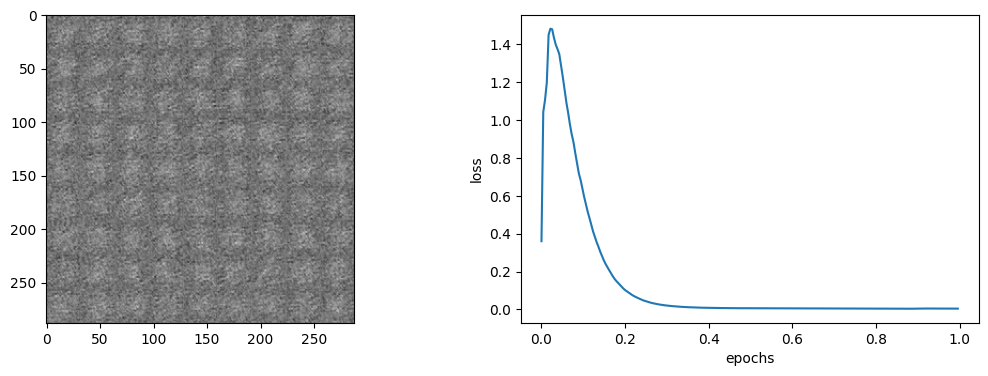

epoch: 3, loss: 0.0016699084, mu: 0.9962077057: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


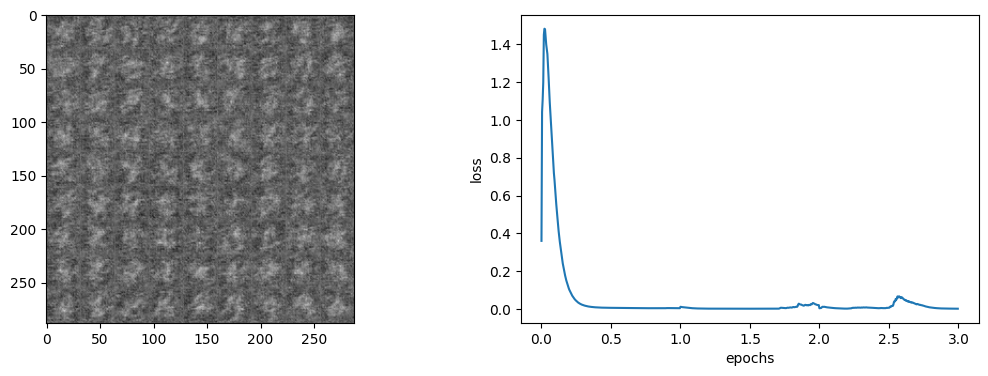

epoch: 6, loss: 0.0007425594, mu: 0.9972312296: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


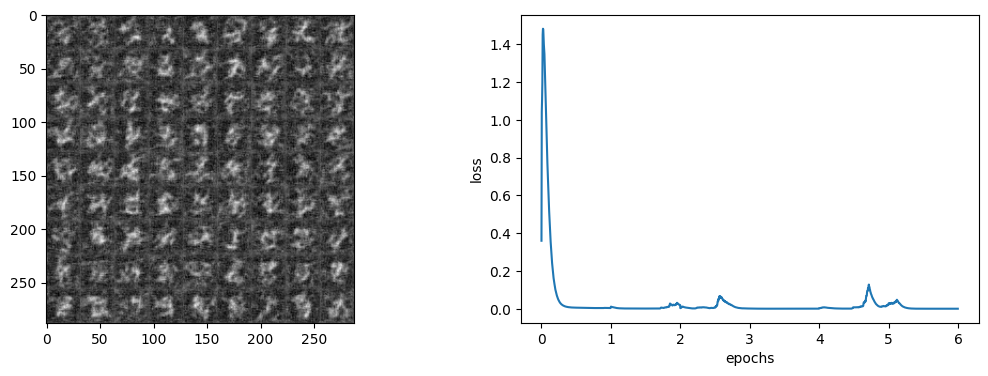

epoch: 9, loss: 0.0006271104, mu: 0.9977723417: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


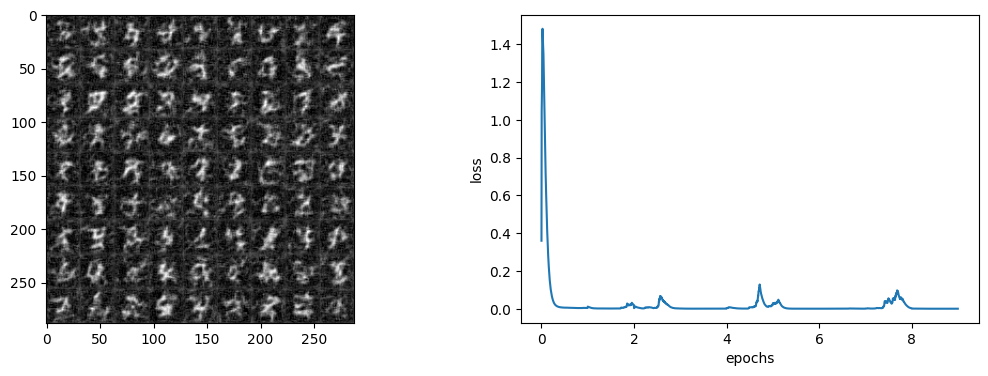

epoch: 12, loss: 0.0119265699, mu: 0.9980291257: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


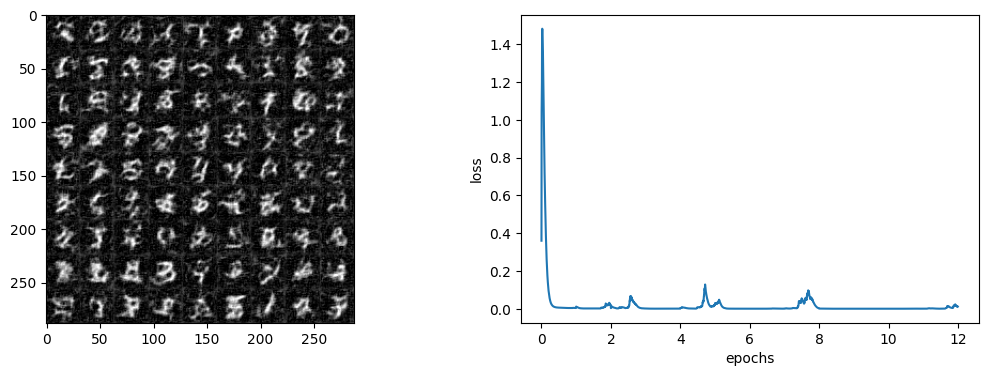

epoch: 15, loss: 0.0010530609, mu: 0.9982627550: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


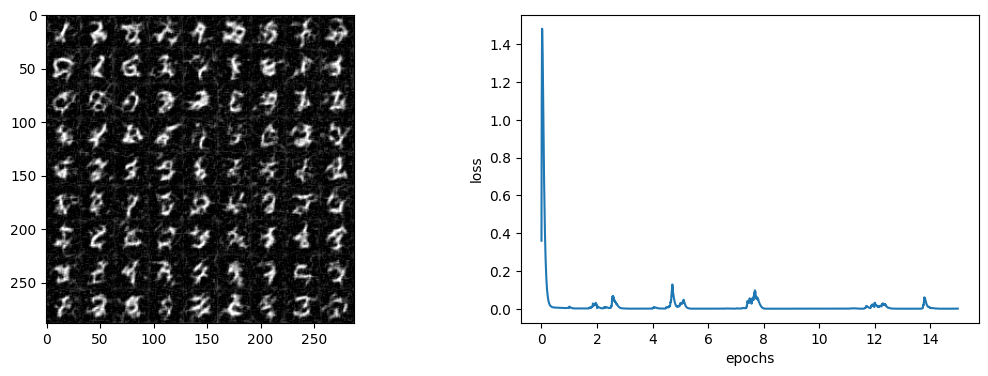

epoch: 18, loss: 0.0006236004, mu: 0.9983983685: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


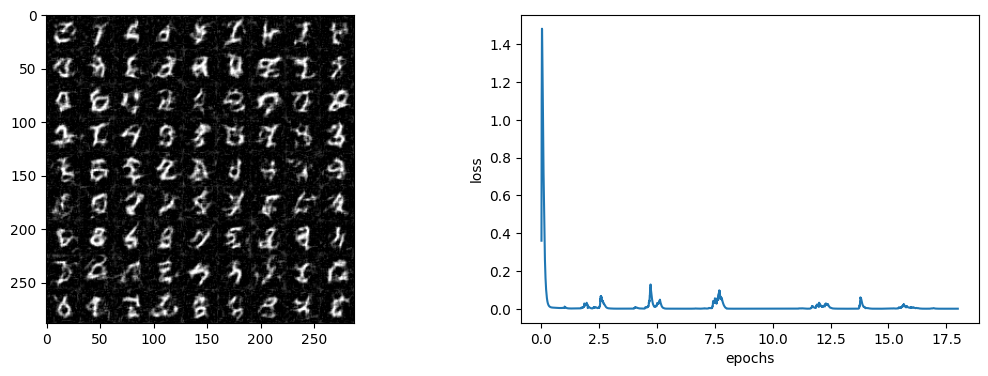

epoch: 21, loss: 0.0607853518, mu: 0.9985143425: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


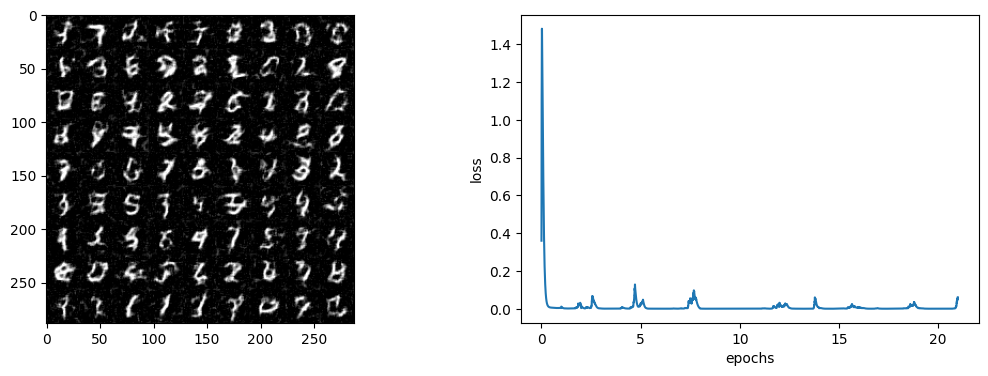

epoch: 24, loss: 0.0151667604, mu: 0.9986146552: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


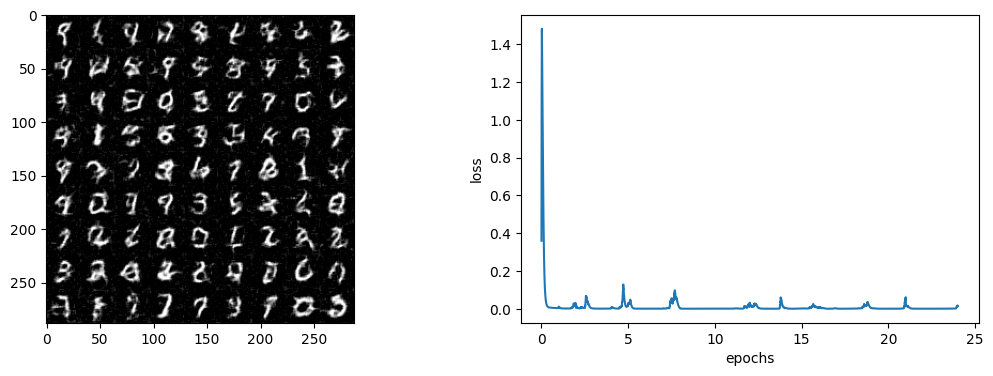

epoch: 27, loss: 0.0116083753, mu: 0.9986856518: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


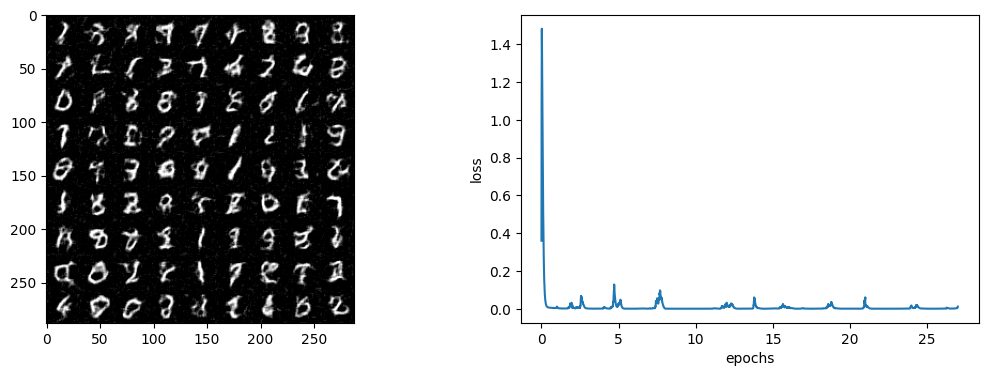

epoch: 30, loss: 0.0049947487, mu: 0.9987647805: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


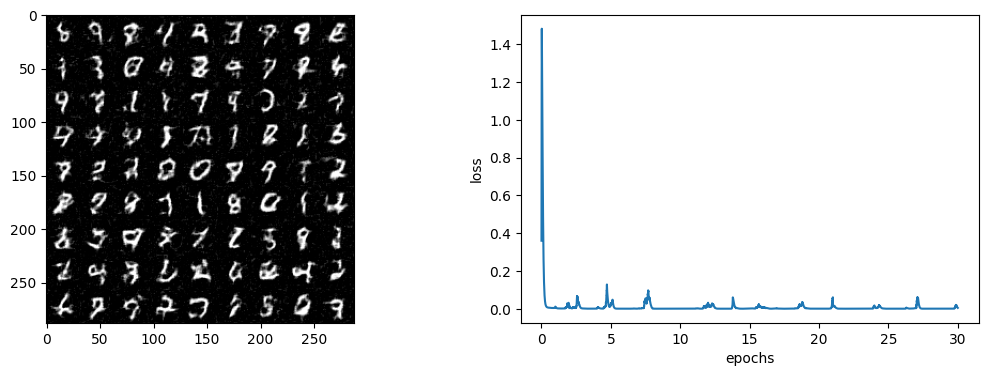

epoch: 33, loss: 0.0009497574, mu: 0.9988215387: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


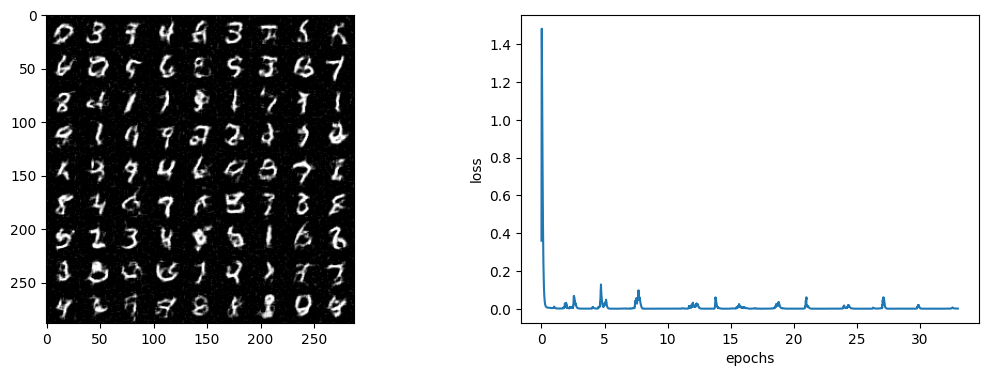

epoch: 36, loss: 0.0008319414, mu: 0.9988733100: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


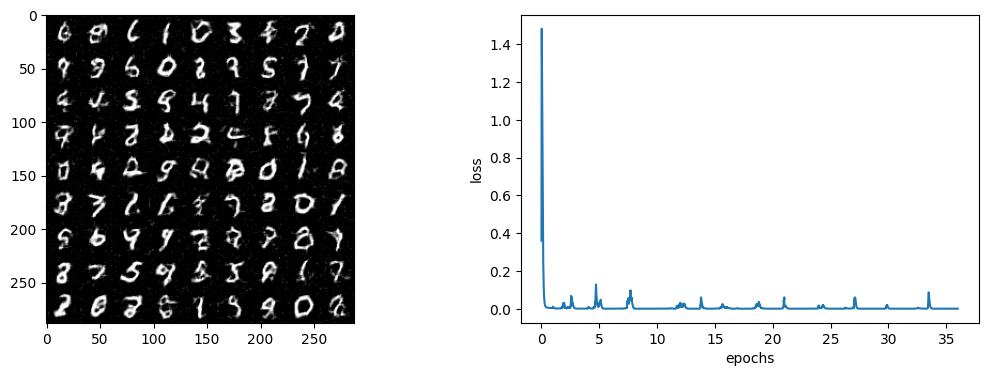

epoch: 39, loss: 0.0006841072, mu: 0.9989092486: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


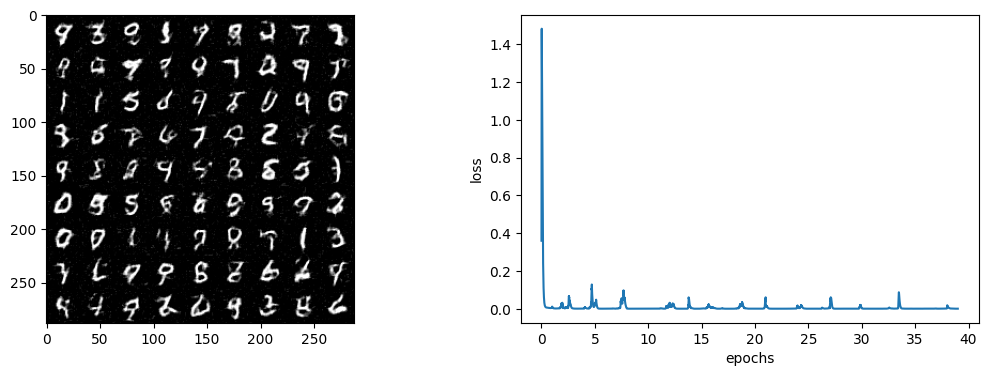

epoch: 42, loss: 0.0007224207, mu: 0.9989537458: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


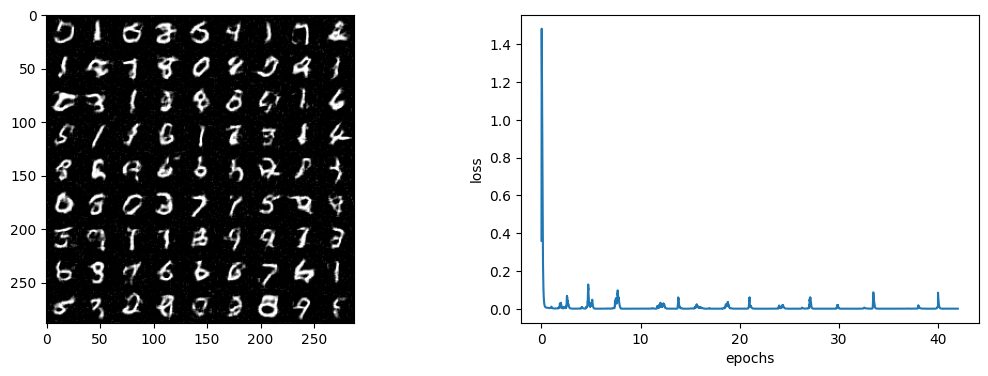

epoch: 45, loss: 0.0007857945, mu: 0.9989848069: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


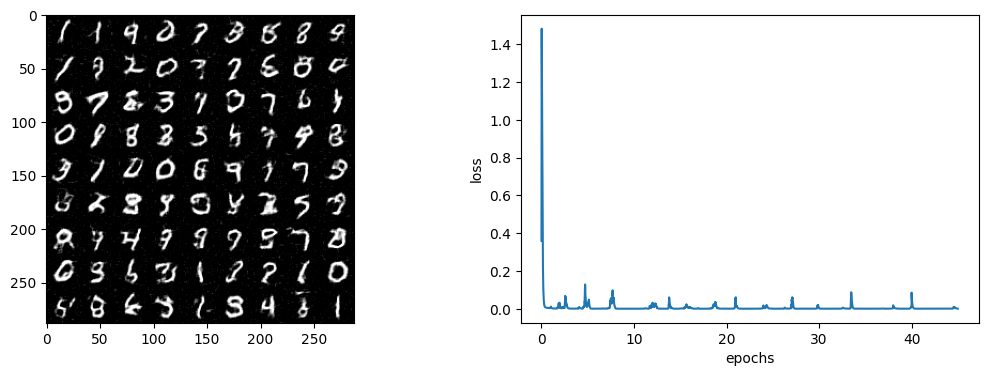

epoch: 48, loss: 0.0007602950, mu: 0.9990140768: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


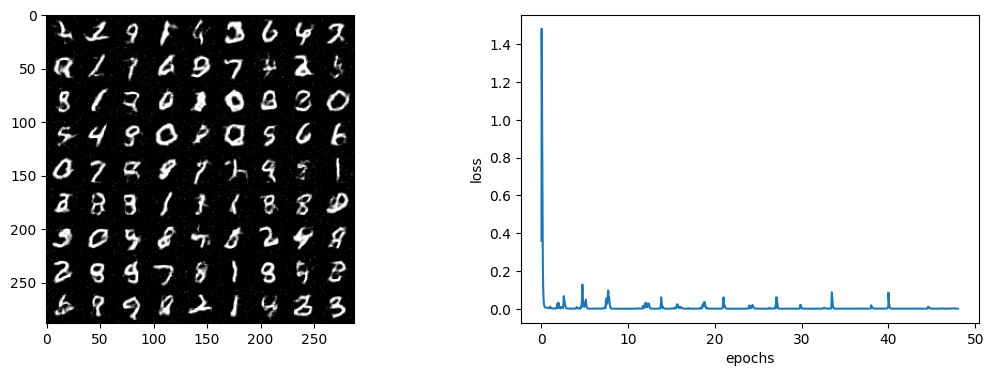

epoch: 51, loss: 0.0006809305, mu: 0.9990505752: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


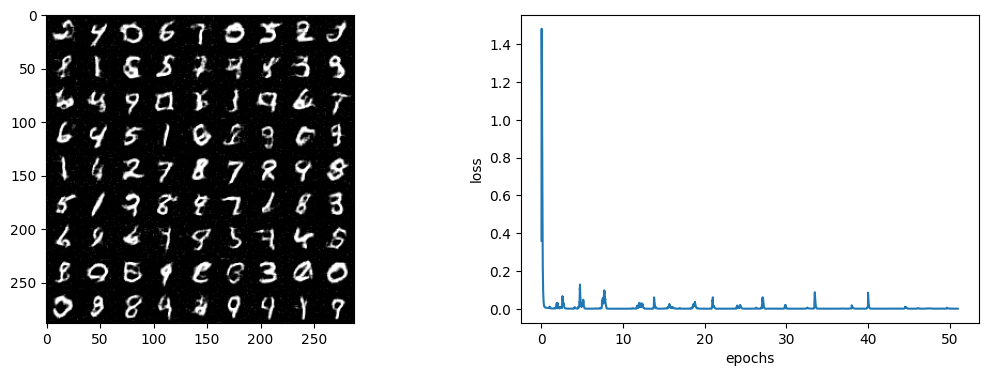

epoch: 54, loss: 0.0008208945, mu: 0.9990762234: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


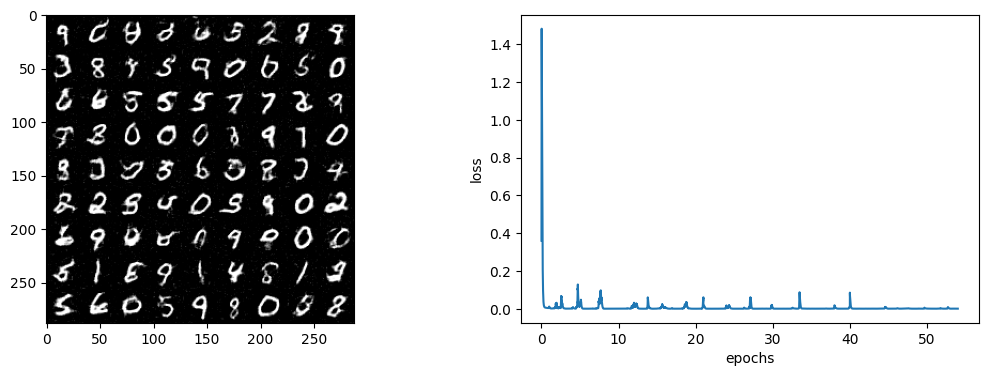

epoch: 57, loss: 0.0007496871, mu: 0.9991005224: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


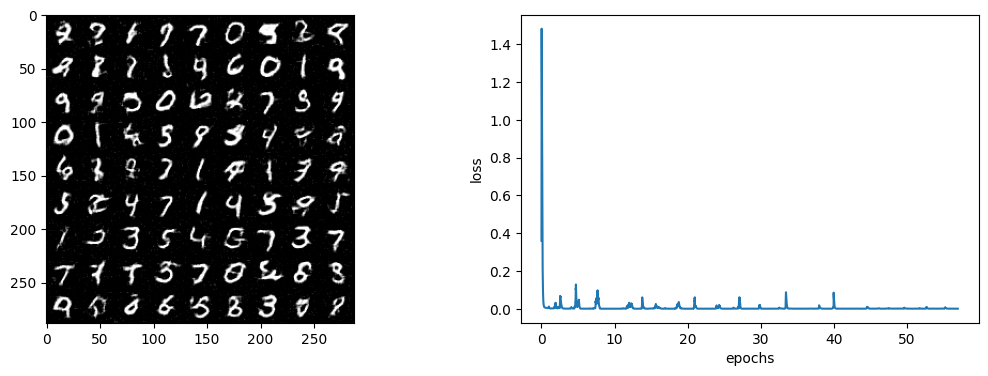

epoch: 60, loss: 0.0007958755, mu: 0.9991235758: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


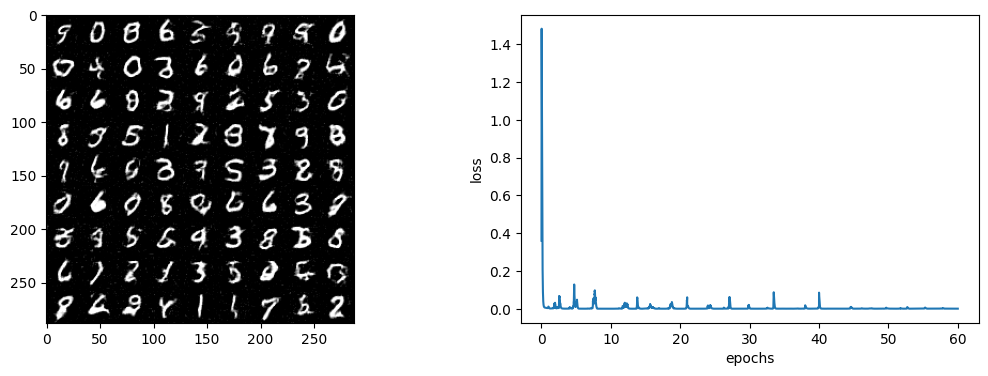

epoch: 63, loss: 0.0008433059, mu: 0.9991454771: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


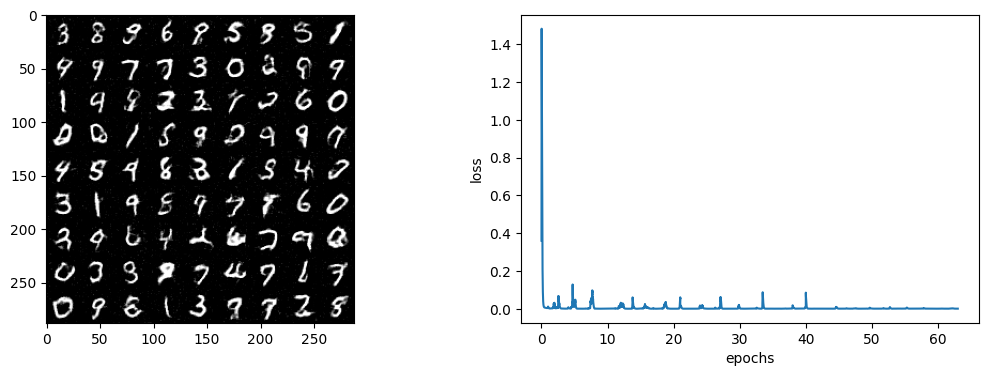

epoch: 66, loss: 0.0010000258, mu: 0.9991594798: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


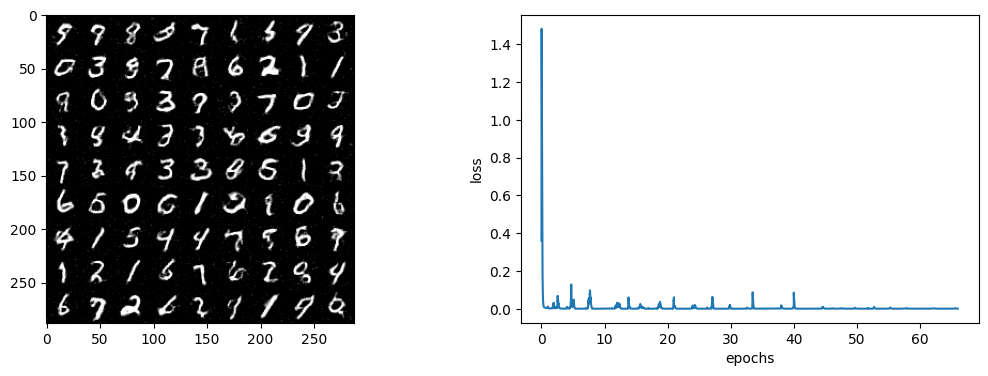

epoch: 69, loss: 0.0010357416, mu: 0.9991796440: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


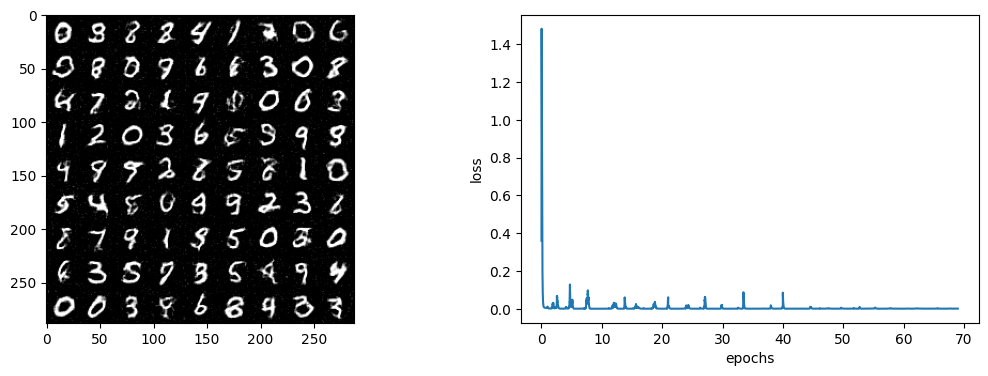

epoch: 72, loss: 0.0010174037, mu: 0.9991988634: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


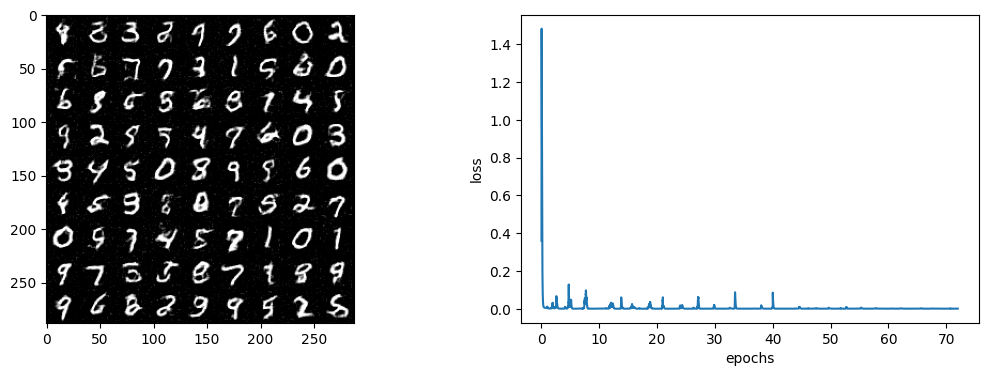

epoch: 75, loss: 0.0006831332, mu: 0.9992111837: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


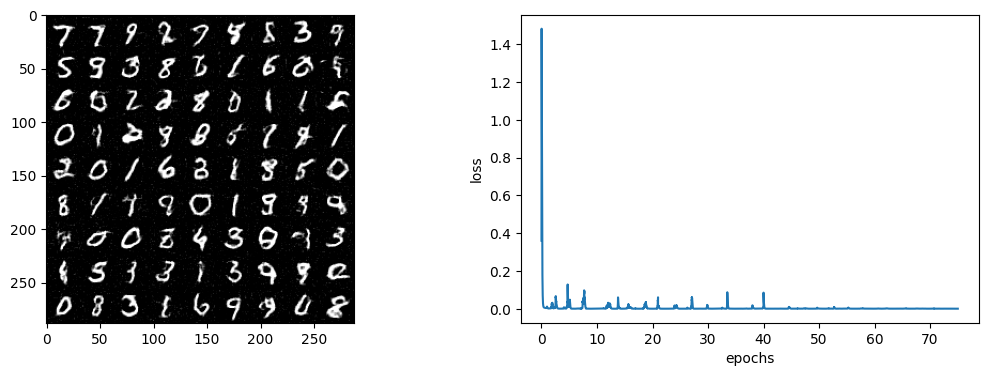

epoch: 78, loss: 0.0009906048, mu: 0.9992289697: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


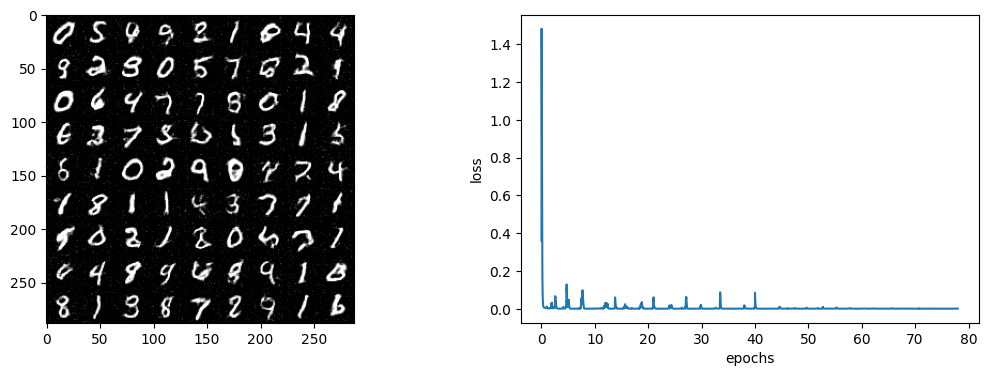

epoch: 81, loss: 0.0006564272, mu: 0.9992459713: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


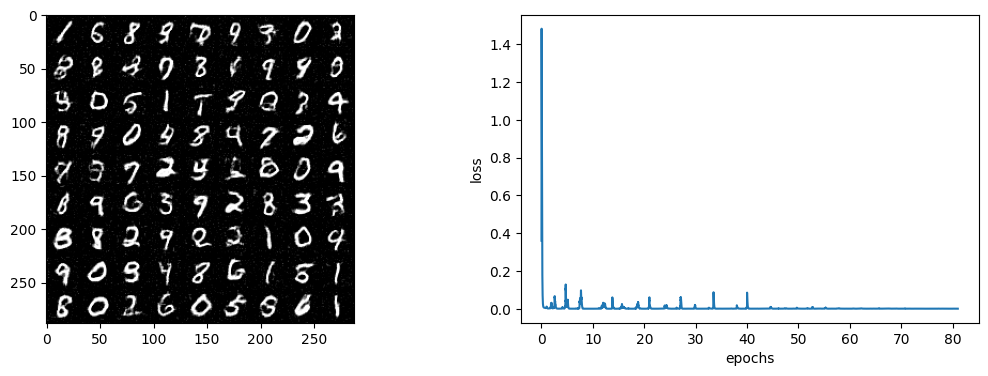

epoch: 84, loss: 0.0008679878, mu: 0.9992568952: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


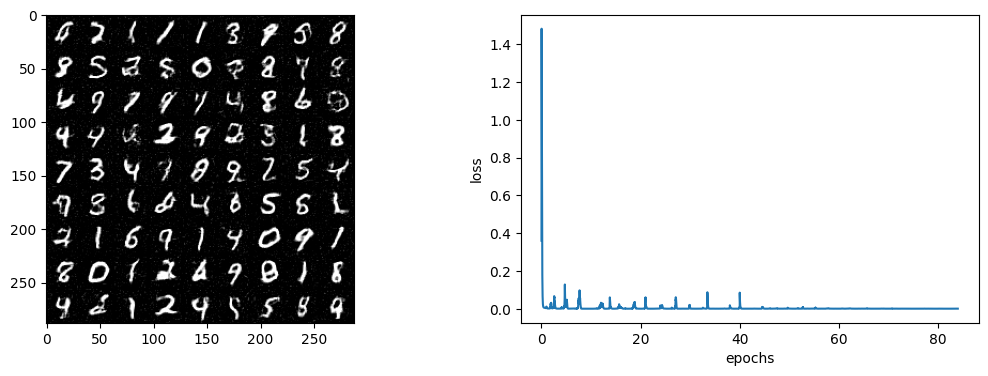

epoch: 87, loss: 0.0007531318, mu: 0.9992675071: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


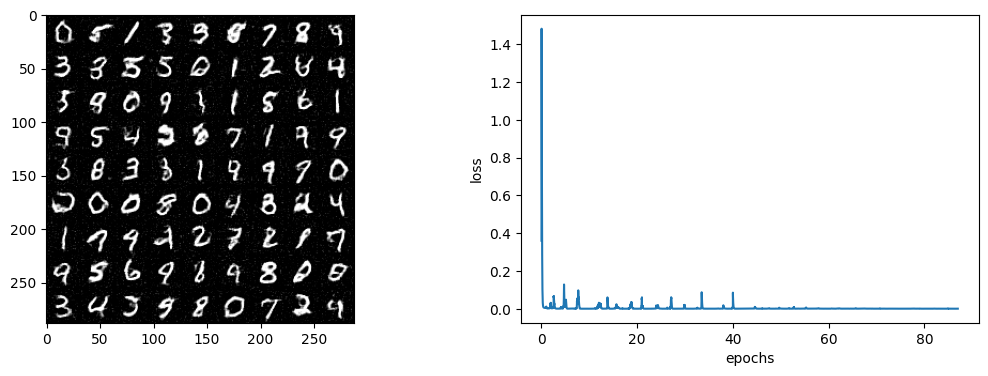

epoch: 90, loss: 0.0006590182, mu: 0.9992828685: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


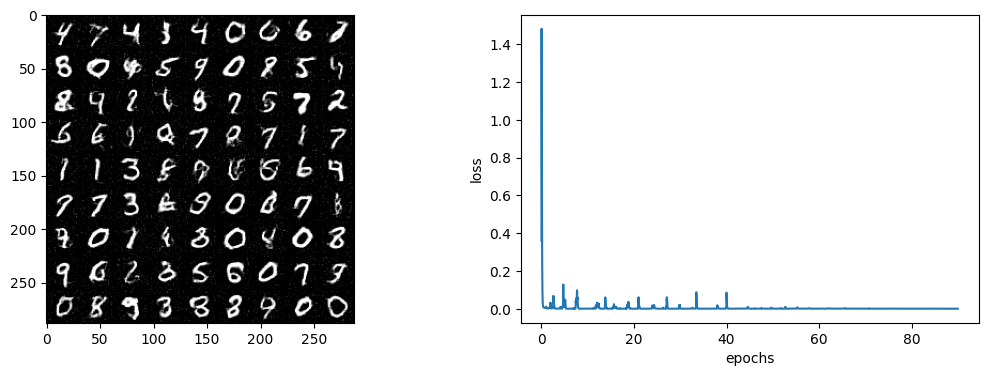

epoch: 93, loss: 0.0006973132, mu: 0.9992927565: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


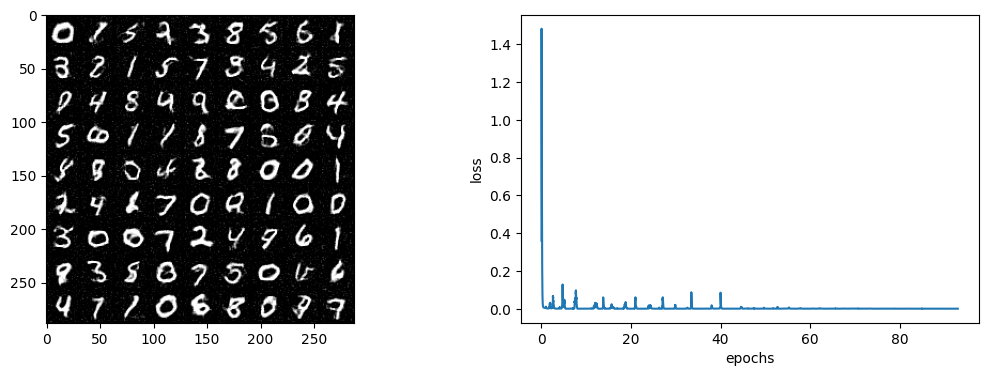

epoch: 96, loss: 0.0005248859, mu: 0.9993023755: 100%|██████████| 235/235 [03:40<00:00,  1.07it/s]


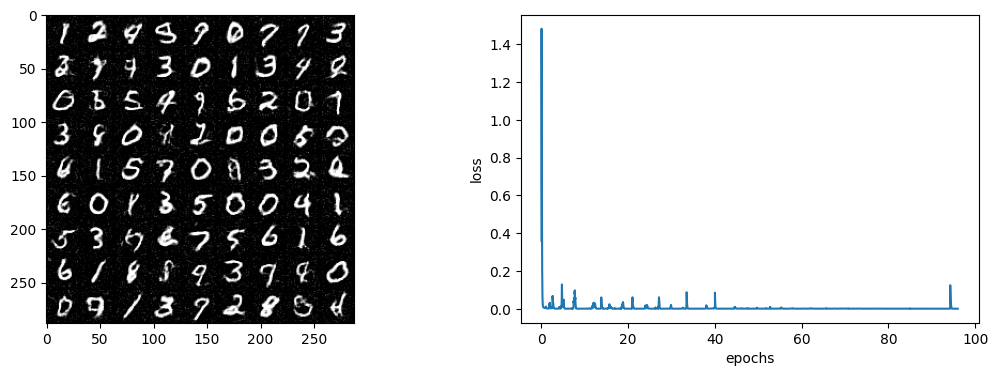

epoch: 99, loss: 0.0005079220, mu: 0.9993163232: 100%|██████████| 235/235 [03:39<00:00,  1.07it/s]


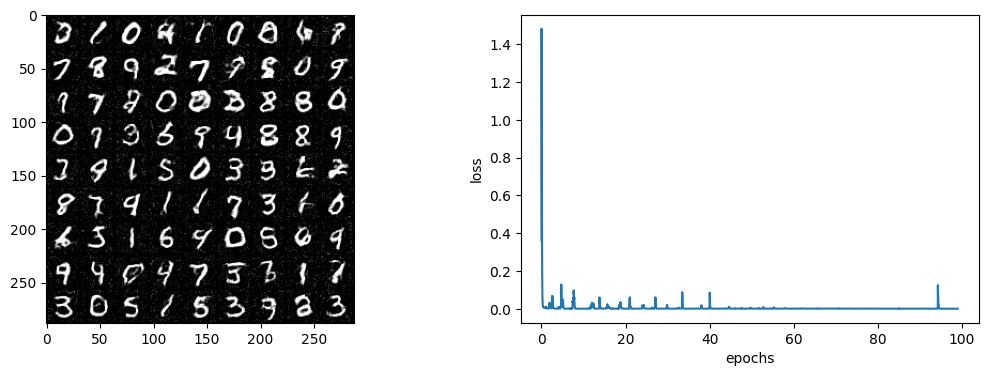

In [7]:
##################
### Problem 1 (d)
##################
n_epoch = 100
n_feat = 256

train(n_epoch=n_epoch, n_feat=n_feat)

# **2. Ablation Study**

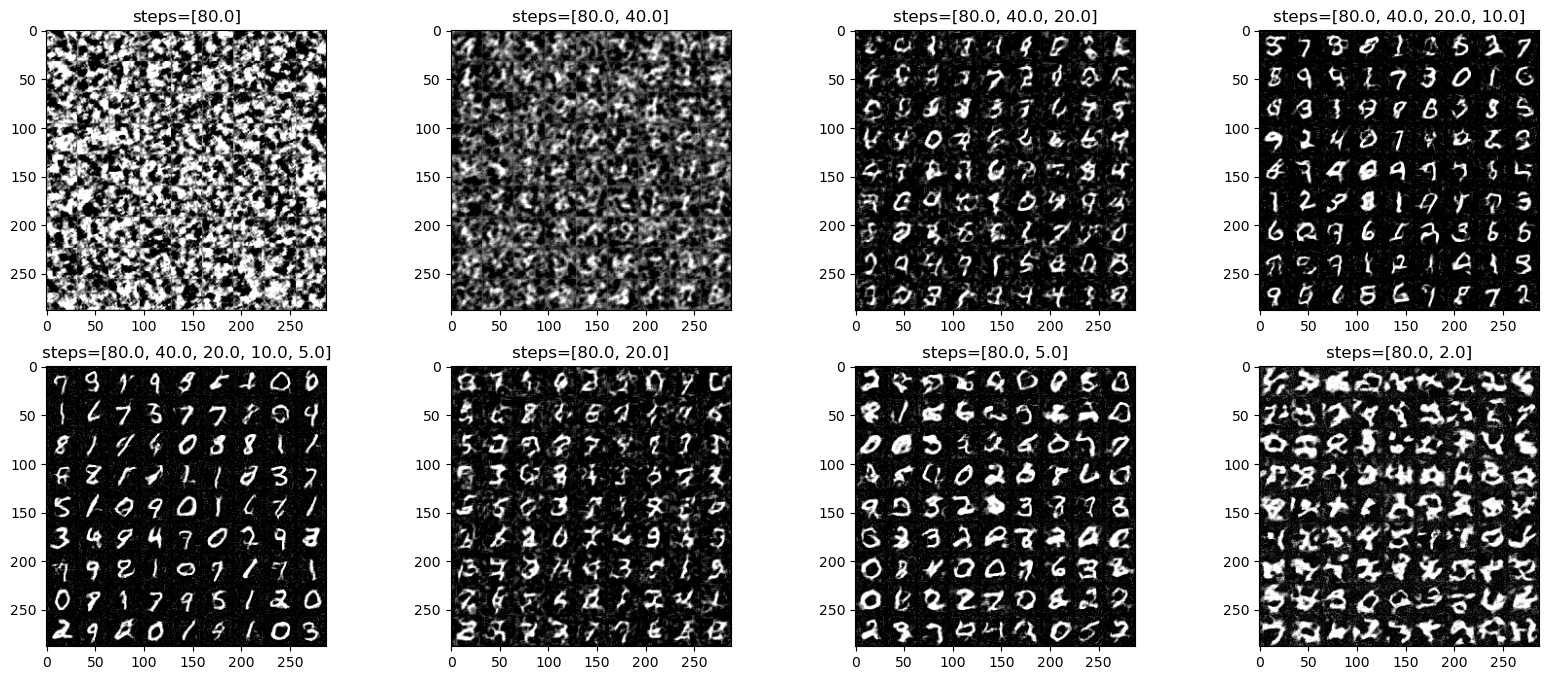

In [28]:
##################
### Problem 2: Ablation Study
##################

n_feat = 256
model = ConsistencyModel(n_channel=1, n_feat=n_feat)
model.load_state_dict(torch.load(f"./models/CM_epoch=99.pt"))
model.to(device)

for x, _ in train_loader:
    x = x.to(device)
    break

with torch.no_grad():
    steps = [5.0, 10.0, 20.0, 40.0, 80.0]
    all_steps = []
    for i in range(1, len(steps) + 1):
        s = steps[-1 : -i - 1 : -1]
        all_steps.append(s)
    all_steps.append([80.0, 20.0])
    all_steps.append([80.0, 5.0])
    all_steps.append([80.0, 2.0])
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes = axes.flatten()
    for i in range(len(all_steps)):
        s = all_steps[i]
        xh = model.sample(
            torch.randn_like(x).to(device=device) * 80.0,
            list(s),
        )
        xh = (xh * 0.5 + 0.5).clamp(0, 1)
        grid = make_grid(xh[:81], nrow=9, padding=0)

        img = ToPILImage()(grid)

        axes[i].imshow(img)
        axes[i].set_title(f"steps={s}")
    plt.show()